In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors


import tqdm
from skimage.feature import hog
from skimage import data, exposure

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

from tools import *

In [2]:
path = "images-photographes"

In [3]:
inames, ilabels, class_names = load_dataset(path)

In [4]:
inames, ilabels, class_names

(['daido-moriyama\\16_daido_moriyama_24.jpg',
  'daido-moriyama\\16_daido_moriyama_25.jpg',
  'daido-moriyama\\16_daido_moriyama_26.jpg',
  'daido-moriyama\\16_daido_moriyama_27.jpg',
  'daido-moriyama\\21_moriyama_mep_050.jpg',
  'daido-moriyama\\21_moriyama_mep_051.jpg',
  'daido-moriyama\\21_moriyama_mep_059.jpg',
  'daido-moriyama\\21_moriyama_mep_063.jpg',
  'daido-moriyama\\21_moriyama_mep_064.jpg',
  'daido-moriyama\\21_moriyama_mep_065.jpg',
  'daido-moriyama\\21_moriyama_mep_066.jpg',
  'daido-moriyama\\21_moriyama_mep_068.jpg',
  'daido-moriyama\\21_moriyama_mep_073.jpg',
  'daido-moriyama\\21_moriyama_mep_075.jpg',
  'daido-moriyama\\21_moriyama_mep_077.jpg',
  'daido-moriyama\\21_moriyama_mep_078.jpg',
  'daido-moriyama\\21_moriyama_mep_079.jpg',
  'daido-moriyama\\21_moriyama_mep_080.jpg',
  'daido-moriyama\\21_moriyama_mep_081.jpg',
  'daido-moriyama\\21_moriyama_mep_082.jpg',
  'daido-moriyama\\21_moriyama_mep_083.jpg',
  'daido-moriyama\\21_moriyama_mep_085.jpg',
  'dai

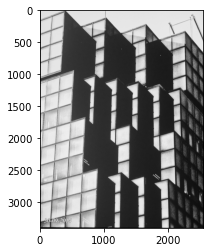

In [5]:
kernel_size = 5
ddepth = cv.CV_16S

p = os.path.join(path, inames[0])
img = cv.imread(p)
src = cv.GaussianBlur(img, (3, 3), 0)
gray= cv.cvtColor(src, cv.COLOR_BGR2GRAY)
dst = cv.Laplacian(gray, ddepth, ksize=kernel_size)
gray = resize_image(dst)
plt.imshow(src)

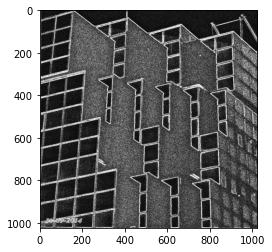

In [6]:
abs_dst = cv.convertScaleAbs(gray)
plt.imshow(abs_dst, cmap= 'gray')

In [7]:
def Resize_image(img):
    return cv.resize(img, (512, 512),interpolation =cv.INTER_LINEAR)

In [8]:
def ComputeLaplacian(img):
    
    src = cv.GaussianBlur(img, (3, 3), 0)
    gray= cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    dst = cv.Laplacian(gray, ddepth, ksize=kernel_size)
    gray = Resize_image(dst)
    abs_dst = cv.convertScaleAbs(gray)

    return abs_dst

In [9]:
def ComputeLaplacians(inames):
    laplacians = []
    for x in tqdm.tqdm(inames):
        p = os.path.join(path, x)
        img = cv.imread(p)
        laplacian = ComputeLaplacian(img)
        laplacian = np.ravel(laplacian)
        laplacians.append(laplacian)
    return laplacians

In [10]:
laplacians = ComputeLaplacians(inames)

100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [00:17<00:00, 15.90it/s]


In [11]:
laplacians = np.array(laplacians)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(laplacians ,ilabels,
                                                    test_size=0.2,stratify=ilabels)

In [13]:
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(224, 262144), (224,)
Test data and target sizes: 
(56, 262144), (56,)


In [14]:
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_Test = scaler.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=1,algorithm='brute')
classifier.fit(X_train, y_train)
test_accuracy = classifier.score(scaler.transform(X_scaled_Test), y_test)
print(test_accuracy)

0.14285714285714285


In [15]:
model_one = SVC(C=40, kernel='linear', max_iter=10000, probability=True)
# Fit on sub-train set
# TODO
model_one.fit(X_train, y_train)
# Evaluate on val set
# TODO
y_hat_test = model_one.predict(X_test)
acc1 = accuracy_score(y_true=y_test, y_pred=y_hat_test)
print(f'--> accuracy = {acc1}')

--> accuracy = 0.35714285714285715


In [16]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
acc3 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",acc3)

Accuracy: 0.3392857142857143


In [17]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=100, learning_rate = 0.01)
# Train Adaboost Classifer
model4 = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_hat = model4.predict(X_test)

acc4 = model4.score(X_test, y_test)
print(f'--> accuracy = {acc4}')

--> accuracy = 0.21428571428571427


In [18]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model_BC = BaggingClassifier(tree.DecisionTreeClassifier(random_state=2))
model_BC.fit(X_train, y_train)
acc5 = model_BC.score(X_test,y_test)
print(f'--> accuracy = {acc5}')

--> accuracy = 0.19642857142857142


In [19]:
ensemble = [('svc', model_one), ('knn', classifier),('rf', clf),('ada', abc), ('Bagging', model_BC)]

eclf3 = VotingClassifier(ensemble)

eclf3 = VotingClassifier(estimators=[
      ('svc', model_one), ('knn', classifier),('rf', clf),('ada', abc), ('Bagging', model_BC)],
       voting='soft',
       flatten_transform=True, weights=[1,1,1,1,1])

#results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)

eclf3 = eclf3.fit(X_train, y_train)
y_pred = eclf3.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'--> accuracy = {acc}')

--> accuracy = 0.21428571428571427
